In [1]:
# Import necesary libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

#apriori library from mlxtend
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import folium
from folium import DivIcon
from folium import plugins
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
#import SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score)

C:\Users\SPECTRE\anaconda3\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\SPECTRE\anaconda3\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


In [2]:
# Establish a connection to the database
connection = sqlite3.connect('accident_data_v1.0.0_2023.db')

# Create a cursor object
cursor = connection.cursor()

In [3]:
# Execute the SQL query
cursor.execute('''SELECT accident_index, SUBSTR(time,1,2), day_of_week
                  FROM accident
                  WHERE accident_year = 2020
                  ''')

# Fetch all the rows from the query result
result = cursor.fetchall()

# Define the column names for the DataFrame
column_names = ['accident_index', 'time', 'day_of_week']

# Convert the list to a DataFrame
accident_df = pd.DataFrame(result, columns=column_names)

# Output the DataFrame
accident_df.head()

accident_index time  day_of_week
0  2020010219808   09            3
1  2020010220496   13            2
2  2020010228005   01            4
3  2020010228006   01            4
4  2020010228011   02            4

In [4]:
accident_df.shape

(91199, 3)

In [5]:
# Get unique values of 'time' and sort them in ascending order
sorted_times = np.sort(accident_df['time'].unique())
sorted_times

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

# function for hour of the day plot

In [6]:
#write function to plot hour of the day
def plot_countplot(df, column_name, order=None):
    # Get the value counts of each unique value in the specified column
    value_counts = df[column_name].value_counts()

    # Calculate the total count
    total_count = value_counts.sum()

    # Plot the count of the specified column with percentage on bars
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    if order is None:
        order = df[column_name].unique()
    
    ax = sns.countplot(data=df, x=column_name, order=order)

    # Add percentages on the bars
    for p in ax.patches:
        percentage = '{:.1f}%'.format((p.get_height() / total_count) * 100)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='top')

    plt.title(f'Count Plot by {column_name}')
    plt.xlabel(column_name)
    plt.show()

# function for day of the week plot

In [7]:
def plot_weekday(df, column_name, value_mapping, desired_order, title):
    # Replace numeric values with mapped values in the specified column
    df[column_name] = df[column_name].map(value_mapping)

    # Categorize the specified column with the desired order
    df[column_name] = pd.Categorical(df[column_name], categories=desired_order, ordered=True)

    # Plot the count of each category with percentage on bars
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    ax = sns.countplot(data=df, x=column_name)

    # Get the value counts of each unique value in the specified column
    value_counts = df[column_name].value_counts()

    # Calculate the total count
    total_count = value_counts.sum()

    # Add percentages on the bars
    for p in ax.patches:
        percentage = '{:.1f}%'.format((p.get_height() / total_count) * 100)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='top')

    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


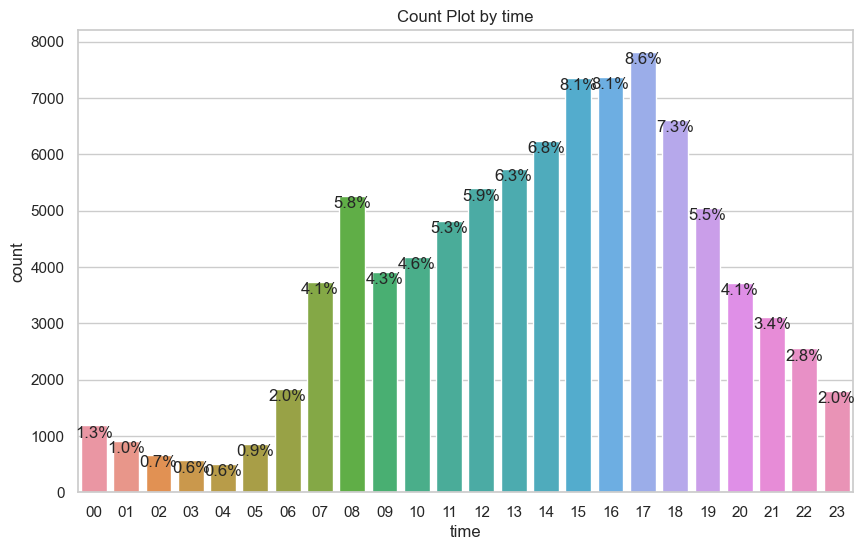

In [8]:
#plot accident occurrence by hour of the day
plot_countplot(accident_df, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


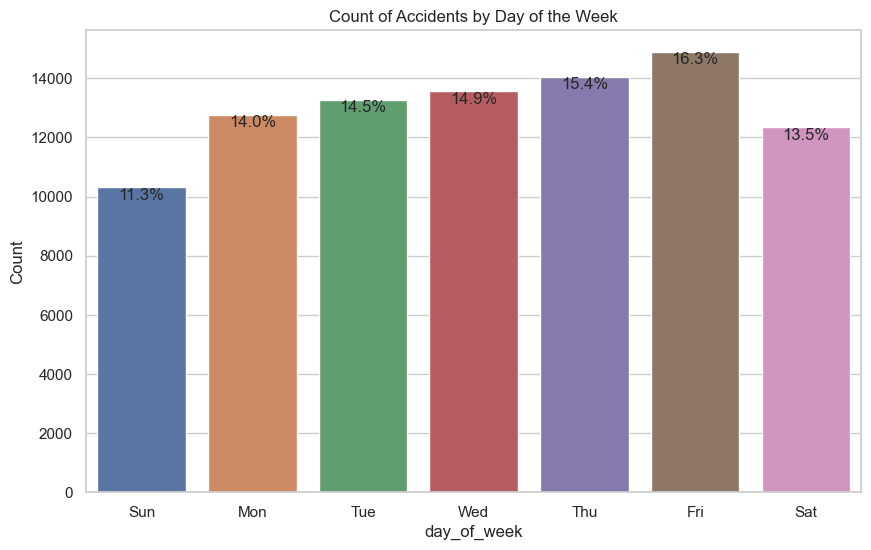

In [9]:
day_mapping = {
    1: 'Sun',
    2: 'Mon',
    3: 'Tue',
    4: 'Wed',
    5: 'Thu',
    6: 'Fri',
    7: 'Sat'
}

desired_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

plot_weekday(accident_df, 'day_of_week', day_mapping, desired_order, 'Count of Accidents by Day of the Week')

# Execute table for motorcycle

In [10]:
# Create a table
# Execute the SQL query
cursor.execute('''
       SELECT a.accident_index,
       SUBSTR(time, 1, 2) AS hour,
       day_of_week,
       CASE
           WHEN vehicle_type IN (2, 3) THEN '125cc and below'
           WHEN vehicle_type == 4 THEN 'over 125cc'
           WHEN vehicle_type == 5 THEN 'up to 500cc'
       END AS vehicle_category
FROM accident AS a
JOIN vehicle AS v ON a.accident_index = v.accident_index
WHERE a.accident_year == 2020 AND vehicle_type IN (2,3,4,5)
ORDER by hour
                  ''')
# Fetch all the rows from the query result
result1 = cursor.fetchall()

# Define the column names for the DataFrame
column_names1 = ['accident_index', 'time', 'day_of_week', 'vehicle_type']

# Convert the list to a DataFrame
cycle_df = pd.DataFrame(result1, columns=column_names1)

# Output the DataFrame
cycle_df.head()

accident_index time  day_of_week     vehicle_type
0  2020010228693   00            2  125cc and below
1  2020010228865   00            3      up to 500cc
2  2020010229710   00            7       over 125cc
3  2020010230362   00            1  125cc and below
4  2020010230698   00            5  125cc and below

In [11]:
cycle_df.shape

(14126, 4)

In [12]:
cycle_df.isna().sum()

accident_index    0
time              0
day_of_week       0
vehicle_type      0
dtype: int64

In [13]:
cycle_df.isin([-1]).sum()

accident_index    0
time              0
day_of_week       0
vehicle_type      0
dtype: int64

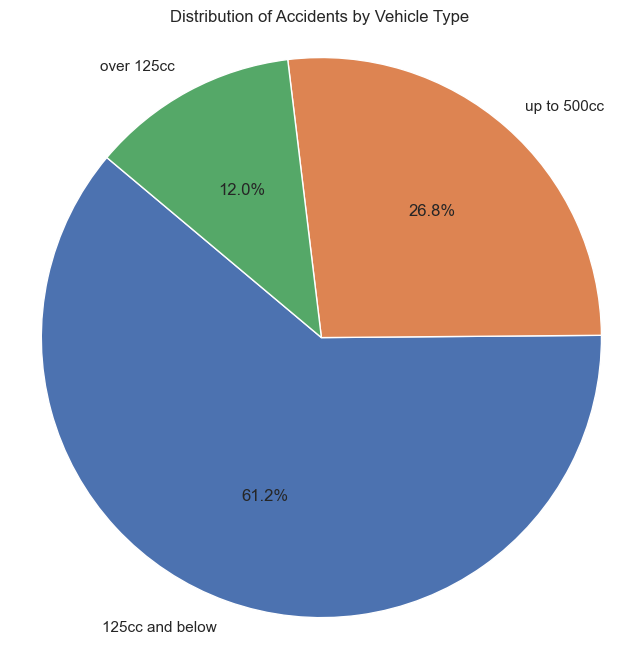

In [14]:
# Calculate the accident counts for each vehicle type
vehicle_type_counts = cycle_df['vehicle_type'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(vehicle_type_counts, labels=vehicle_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Accidents by Vehicle Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Motorcycle 125cc and under

In [15]:
#under_125cc = acc_veh_join.query('vehicle_type == 2 | vehicle_type == 3')
under_125cc = cycle_df.query('vehicle_type == "125cc and below"')
under_125cc

accident_index time  day_of_week     vehicle_type
0      2020010228693   00            2  125cc and below
3      2020010230362   00            1  125cc and below
4      2020010230698   00            5  125cc and below
5      2020010232553   00            7  125cc and below
7      2020010235428   00            1  125cc and below
...              ...  ...          ...              ...
14117  2020552100160   23            1  125cc and below
14118  202060Y128068   23            2  125cc and below
14122  2020990966852   23            5  125cc and below
14123  2020990975198   23            2  125cc and below
14125  2020990984518   23            6  125cc and below

[8651 rows x 4 columns]

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


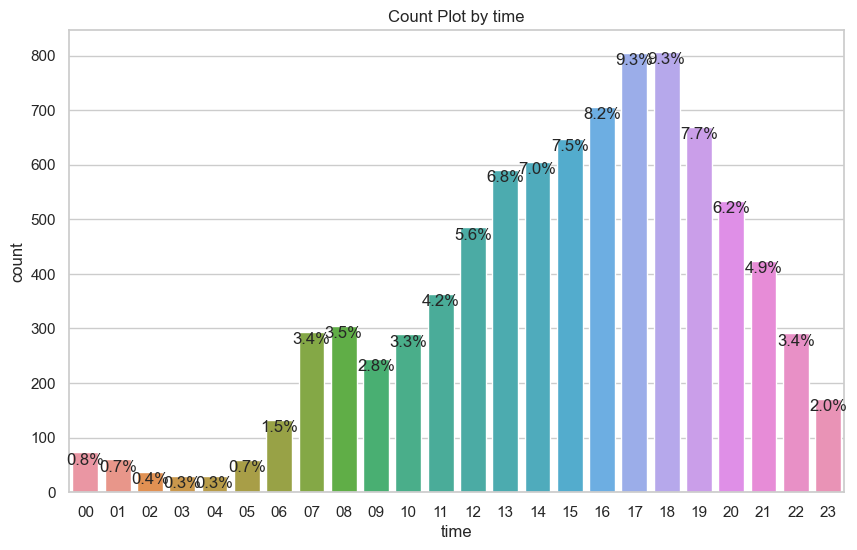

In [16]:
#plot accident occurrence for motocycles below 125cc by hour of the day
#The capacity of a vehicle can impact accident, hence reason for looking at some specific motocycles
plot_countplot(under_125cc, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


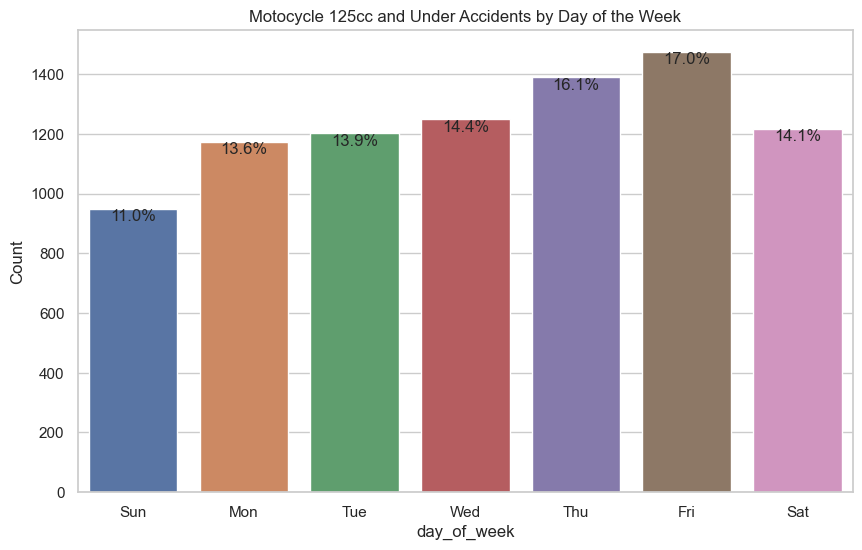

In [17]:
#plot accident day of the week for motocycle under 125cc
plot_weekday(under_125cc, 'day_of_week', day_mapping, desired_order, 'Motocycle 125cc and Under Accidents by Day of the Week')

# Motocycle over 125cc

In [18]:
#under_125cc = acc_veh_join.query('vehicle_type == 2 | vehicle_type == 3')
above_125cc = cycle_df.query('vehicle_type == "over 125cc"')
above_125cc

accident_index time  day_of_week vehicle_type
2      2020010229710   00            7   over 125cc
8      2020010236603   00            7   over 125cc
15     2020010243727   00            1   over 125cc
26     2020010258183   00            6   over 125cc
38     2020010268352   00            6   over 125cc
...              ...  ...          ...          ...
14101  2020470983851   23            6   over 125cc
14105  2020500962890   23            2   over 125cc
14106  2020500975602   23            4   over 125cc
14110  2020520001805   23            5   over 125cc
14120  2020622100050   23            6   over 125cc

[1691 rows x 4 columns]

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


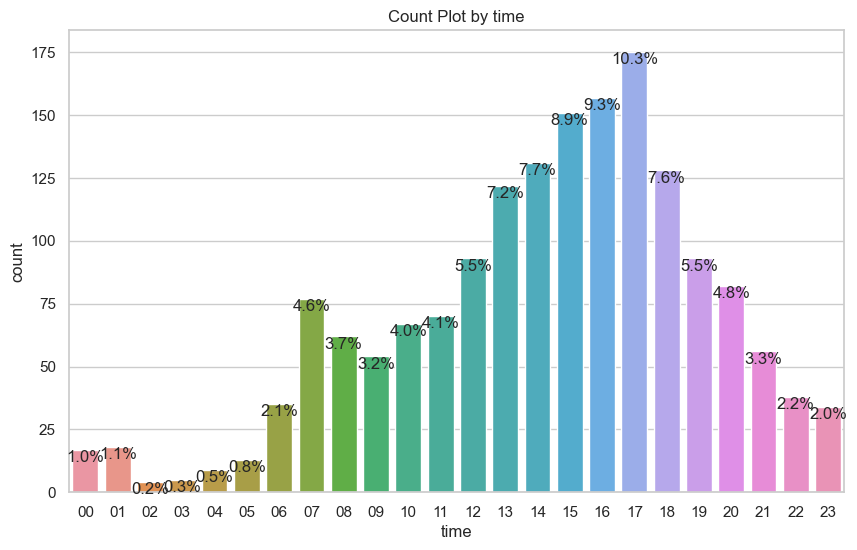

In [19]:
#The capacity of a vehicle can impact accident, hence reason for looking at some specific motocycles
plot_countplot(above_125cc, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


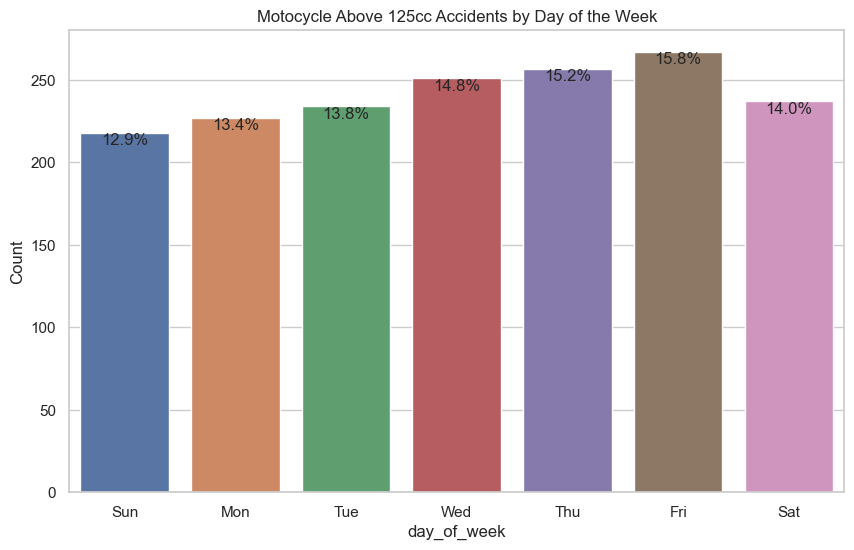

In [20]:
#plot accident day of the week for motocycle above 125cc
plot_weekday(above_125cc, 'day_of_week', day_mapping, desired_order, 'Motocycle Above 125cc Accidents by Day of the Week')

# Motocycle Up to 500cc

In [21]:
#under_125cc = acc_veh_join.query('vehicle_type == 2 | vehicle_type == 3')
over_500cc = cycle_df.query('vehicle_type == "up to 500cc"')
over_500cc

accident_index time  day_of_week vehicle_type
1      2020010228865   00            3  up to 500cc
6      2020010232738   00            1  up to 500cc
11     2020010240265   00            6  up to 500cc
20     2020010252424   00            7  up to 500cc
28     2020010259526   00            5  up to 500cc
...              ...  ...          ...          ...
14092  2020460990391   23            5  up to 500cc
14115  2020549273620   23            2  up to 500cc
14119  2020622001008   23            3  up to 500cc
14121  2020990946977   23            6  up to 500cc
14124  2020990982529   23            7  up to 500cc

[3784 rows x 4 columns]

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


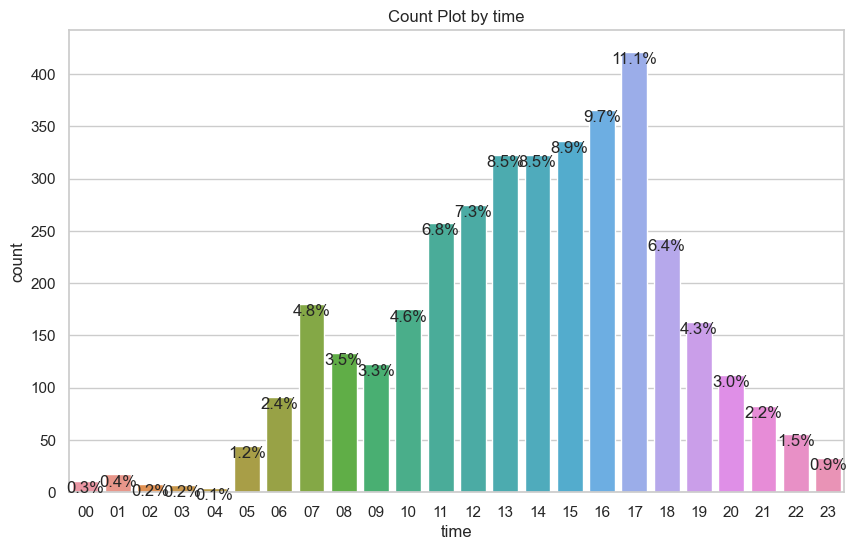

In [22]:
#plot accident occurrence for motocycles below 125cc by hour of the day
#The capacity of a vehicle can impact accident, hence reason for looking at some specific motocycles
plot_countplot(over_500cc, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


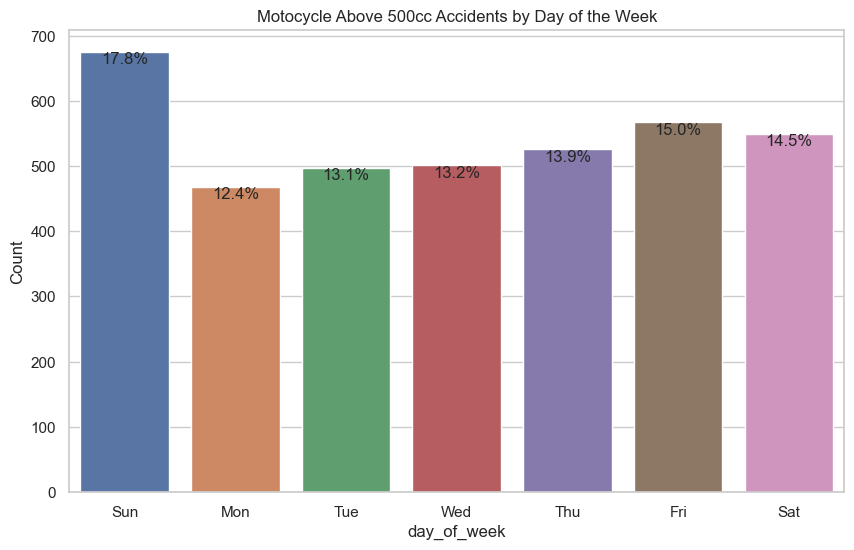

In [23]:
#plot accident day of the week for motocycle under 125cc
plot_weekday(over_500cc, 'day_of_week', day_mapping, desired_order, 'Motocycle Above 500cc Accidents by Day of the Week')

# Compare the three motocycles with a plot

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


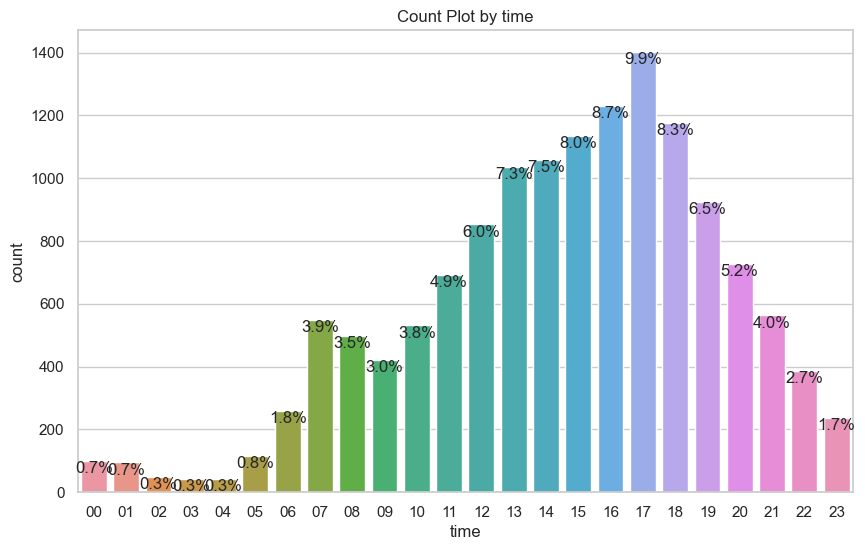

In [24]:
#plot accident occurrence for motocycles below 125cc by hour of the day
#The capacity of a vehicle can impact accident, hence reason for looking at some specific motocycles
plot_countplot(cycle_df, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


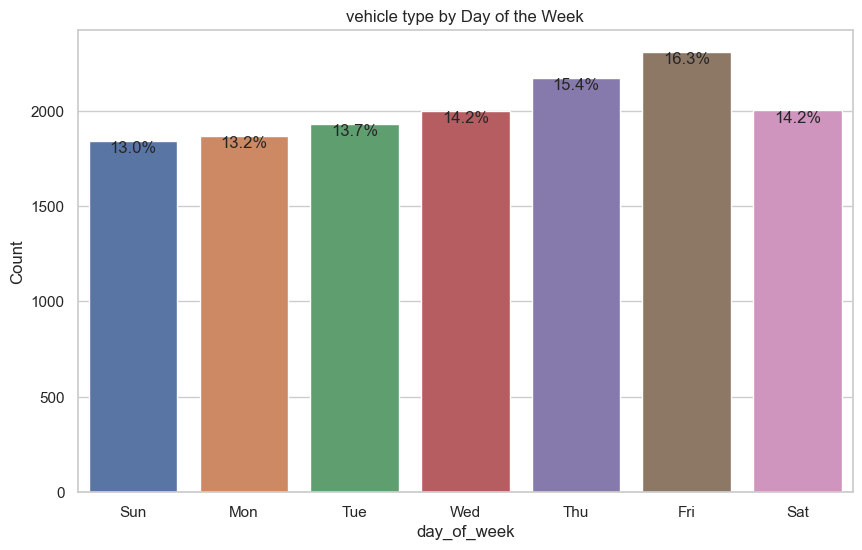

In [25]:
#plot accident day of the week for motocycle under 125cc
plot_weekday(cycle_df, 'day_of_week', day_mapping, desired_order, 'vehicle type by Day of the Week')

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


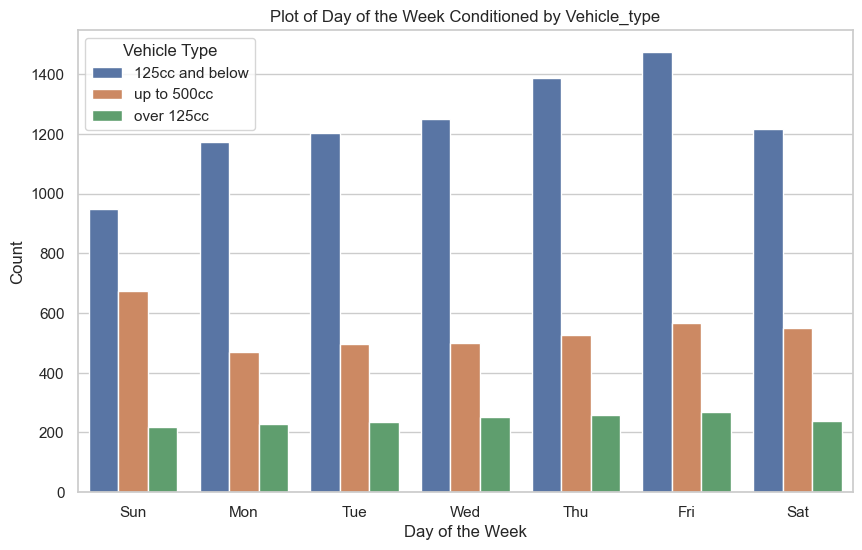

In [26]:
# Define the desired order of days of the week
desired_order = [ 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Plot the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=cycle_df, x='day_of_week', hue='vehicle_type', hue_order=cycle_df['vehicle_type'].unique(), order=desired_order)
plt.title('Plot of Day of the Week Conditioned by Vehicle_type')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Vehicle Type')
plt.show()


# significant hours of the day and days of the week for pedestrians

In [27]:
# Create a table
# Execute the SQL query
cursor.execute('''
    SELECT a.accident_index,
           SUBSTR(a.time, 1, 2) AS time,
           a.day_of_week
    FROM accident AS a
    JOIN casualty AS c ON a.accident_index = c.accident_index
    WHERE a.accident_year = 2020 AND c.casualty_class = 3
''')

# Fetch all the rows from the query result
cas_result = cursor.fetchall()

# Define the column names for the DataFrame
column_names = ['accident_index', 'time', 'day_of_week']

# Convert the list to a DataFrame
ped_df = pd.DataFrame(cas_result, columns=column_names)

# Output the DataFrame
ped_df

accident_index time  day_of_week
0      2020010219808   09            3
1      2020010220496   13            2
2      2020010220496   13            2
3      2020010228005   01            4
4      2020010228006   01            4
...              ...  ...          ...
14745  2020991023621   10            3
14746  2020991023880   17            2
14747  2020991024526   12            3
14748  2020991029573   15            6
14749  2020991032575   13            3

[14750 rows x 3 columns]

In [28]:
ped_df.shape

(14750, 3)

In [29]:
ped_df.isna().sum()

accident_index    0
time              0
day_of_week       0
dtype: int64

In [30]:
ped_df.isin([-1]).sum()

accident_index    0
time              0
day_of_week       0
dtype: int64

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


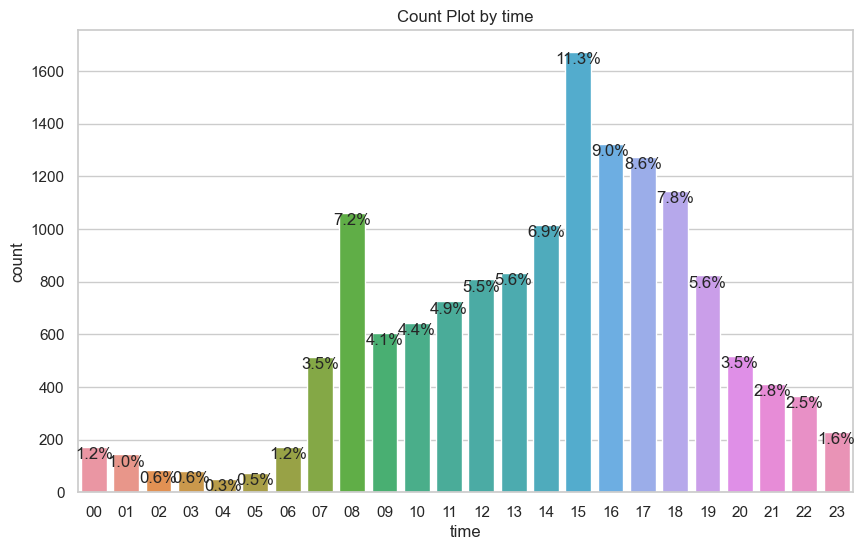

In [31]:
#plot pedestrian involved in accident by hour of the day
plot_countplot(ped_df, 'time', order=sorted_times)

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


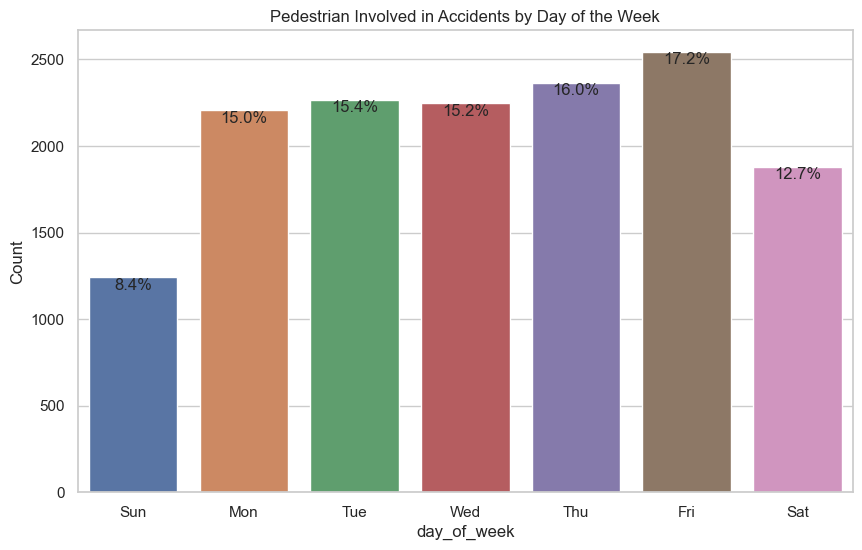

In [32]:
#plot accident day of the week for motocycle under 125cc
plot_weekday(ped_df, 'day_of_week', day_mapping, desired_order, 'Pedestrian Involved in Accidents by Day of the Week')

# 4- explore the impact of selected variables on accident severity using the apriori algorithm 

In [33]:
# join casualty and vehicle tables on accident table to find the best variables
# Execute the SQL query
cursor.execute('''SELECT *
                  FROM accident AS a
                  JOIN vehicle AS v ON a.accident_index = v.accident_index
                  JOIN casualty AS c ON a.accident_index = c.accident_index
                  WHERE a.accident_year = 2020
                  ''')

# Fetch all the rows from the query result
rows = cursor.fetchall()

# Retrieve the column names from the cursor's description
columns = [column[0] for column in cursor.description]

# Put the fetched rows in a DataFrame with the column names
merged = pd.DataFrame(rows, columns=columns)

# Drop duplicates of any duplicated columns
merged = merged.loc[:, ~merged.columns.duplicated()]

# Output the DataFrame
merged

accident_index  accident_year accident_reference  \
0       2020010219808           2020          010219808   
1       2020010220496           2020          010220496   
2       2020010220496           2020          010220496   
3       2020010228005           2020          010228005   
4       2020010228006           2020          010228006   
...               ...            ...                ...   
220430  2020991030297           2020          991030297   
220431  2020991030297           2020          991030297   
220432  2020991030900           2020          991030900   
220433  2020991030900           2020          991030900   
220434  2020991032575           2020          991032575   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    529337.0                176237.0  -0.139253  51.470327   
2                    529337.0                176237.0  -0.139253  51.470327   
3                    526432.0                182761.0  -0.178719  51.529614   
4                    538676.0                184371.0  -0.001683  51.541210   
...                       ...                     ...        ...        ...   
220430               383664.0                810646.0  -2.271903  57.186317   
220431               383664.0                810646.0  -2.271903  57.186317   
220432               277161.0                674852.0  -3.968753  55.950940   
220433               277161.0                674852.0  -3.968753  55.950940   
220434               240402.0                681950.0  -4.561040  56.003843   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   1  ...   
1                  1                  3                   1  ...   
2                  1                  3                   1  ...   
3                  1                  3                   1  ...   
4                  1                  2                   1  ...   
...              ...                ...                 ...  ...   
220430            99                  2                   2  ...   
220431            99                  2                   2  ...   
220432            99                  3                   2  ...   
220433            99                  3                   2  ...   
220434            99                  3                   1  ...   

        age_band_of_casualty casualty_severity  pedestrian_location  \
0                          6                 3                    9   
1                          1                 3                    1   
2                          1                 3                    1   
3                          5                 3                    5   
4                          8                 2                    4   
...                      ...               ...                  ...   
220430                     7                 2                    0   
220431                     7                 2                    0   
220432                    11                 3                    0   
220433                    11                 3                    0   
220434                     8                 3                    9   

       pedestrian_movement  car_passenger bus_or_coach_passenger  \
0                        5              0                      0   
1                        1              0                      0   
2                        1              0                      0   
3                        9              0                      0   
4                        1              0                      0   
...                    ...            ...                    ...   
220430                   0              0                      0   
220431                   0              0                      0   
220432                   0              0                      0   

In [34]:
#extract just numeric columns
num_data = merged.select_dtypes([np.number])
num_data

accident_year  location_easting_osgr  location_northing_osgr  \
0                2020               521389.0                175144.0   
1                2020               529337.0                176237.0   
2                2020               529337.0                176237.0   
3                2020               526432.0                182761.0   
4                2020               538676.0                184371.0   
...               ...                    ...                     ...   
220430           2020               383664.0                810646.0   
220431           2020               383664.0                810646.0   
220432           2020               277161.0                674852.0   
220433           2020               277161.0                674852.0   
220434           2020               240402.0                681950.0   

        longitude   latitude  police_force  accident_severity  \
0       -0.254001  51.462262             1                  3   
1       -0.139253  51.470327             1                  3   
2       -0.139253  51.470327             1                  3   
3       -0.178719  51.529614             1                  3   
4       -0.001683  51.541210             1                  2   
...           ...        ...           ...                ...   
220430  -2.271903  57.186317            99                  2   
220431  -2.271903  57.186317            99                  2   
220432  -3.968753  55.950940            99                  3   
220433  -3.968753  55.950940            99                  3   
220434  -4.561040  56.003843            99                  3   

        number_of_vehicles  number_of_casualties  day_of_week  ...  \
0                        1                     1            3  ...   
1                        1                     2            2  ...   
2                        1                     2            2  ...   
3                        1                     1            4  ...   
4                        1                     1            4  ...   
...                    ...                   ...          ...  ...   
220430                   2                     1            4  ...   
220431                   2                     1            4  ...   
220432                   2                     1            3  ...   
220433                   2                     1            3  ...   
220434                   1                     1            3  ...   

        age_band_of_casualty  casualty_severity  pedestrian_location  \
0                          6                  3                    9   
1                          1                  3                    1   
2                          1                  3                    1   
3                          5                  3                    5   
4                          8                  2                    4   
...                      ...                ...                  ...   
220430                     7                  2                    0   
220431                     7                  2                    0   
220432                    11                  3                    0   
220433                    11                  3                    0   
220434                     8                  3                    9   

        pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                         5              0                       0   
1                         1              0                       0   
2                         1              0                       0   
3                         9              0                       0   
4                         1              0                       0   
...                     ...            ...                     ...   
220430                    0              0                       0   
220431                    0              0                       0   
220432                    

In [35]:
# Replace all occurrences of -1 with NaN
num_data.replace(-1, np.nan, inplace=True)

In [36]:
num_data.isna().sum()

accident_year                             0
location_easting_osgr                    34
location_northing_osgr                   34
longitude                                34
latitude                                 34
                                      ...  
bus_or_coach_passenger                   34
pedestrian_road_maintenance_worker      103
casualty_type                             0
casualty_home_area_type               20270
casualty_imd_decile                   20559
Length: 68, dtype: int64

In [37]:
# Iterate through each column and count missing values
missing_counts = num_data.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_counts[missing_counts > 0]

# Print columns with missing values and their corresponding counts
for column, count in columns_with_missing.items():
    print(f"Column '{column}' has {count} missing value(s)")

Column 'location_easting_osgr' has 34 missing value(s)
Column 'location_northing_osgr' has 34 missing value(s)
Column 'longitude' has 34 missing value(s)
Column 'latitude' has 34 missing value(s)
Column 'local_authority_district' has 2345 missing value(s)
Column 'speed_limit' has 14 missing value(s)
Column 'junction_detail' has 4 missing value(s)
Column 'junction_control' has 93721 missing value(s)
Column 'second_road_class' has 281 missing value(s)
Column 'second_road_number' has 93118 missing value(s)
Column 'pedestrian_crossing_human_control' has 321 missing value(s)
Column 'pedestrian_crossing_physical_facilities' has 314 missing value(s)
Column 'light_conditions' has 1 missing value(s)
Column 'weather_conditions' has 1 missing value(s)
Column 'road_surface_conditions' has 666 missing value(s)
Column 'special_conditions_at_site' has 488 missing value(s)
Column 'carriageway_hazards' has 469 missing value(s)
Column 'did_police_officer_attend_scene_of_accident' has 1 missing value(s)


In [38]:
region = num_data[['longitude', 'latitude', 'location_northing_osgr', 'location_easting_osgr']]

In [39]:
region.isna().sum()

longitude                 34
latitude                  34
location_northing_osgr    34
location_easting_osgr     34
dtype: int64

In [40]:
# Fill missing values with the median of each column
num_data[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']] = region.fillna(region.median())

In [41]:
num_data[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isna().sum()

location_easting_osgr     0
location_northing_osgr    0
longitude                 0
latitude                  0
dtype: int64

In [42]:
# Define function to replace missing values in all columns with mode
def replace_missing_values_with_mode(df):
    for column in df.columns:
        if df[column].isnull().any():
            mode_val = df[column].mode()[0]
            missing_mask = df[column].isnull()
            num_missing = missing_mask.sum()
            mode_values = np.full(num_missing, mode_val)
            df.loc[missing_mask, column] = mode_values

# Call the function to replace missing values with mode (for all columns)
replace_missing_values_with_mode(num_data)

In [43]:
num_data.isna().sum().sum()

0

# Running Apriori

In [44]:
y_label = (num_data['accident_severity'] == 1)

In [45]:
counts = y_label.value_counts()
counts

False    216204
True       4231
Name: accident_severity, dtype: int64

In [46]:
#1 represent fatal while 2 and 3 represent slight and serious accident severity 
#replace 3 with 2 as non_fatal
num_data['accident_severity'].replace(3,2, inplace=True)

In [47]:
# drop selected variables and leave others(input variables)
x = num_data.drop(['accident_severity', 'did_police_officer_attend_scene_of_accident', 'casualty_severity'], axis = 1)

# value to be predicted (output of the prediction)
y = num_data['accident_severity']

In [48]:
#run undersampler on x and y to balance the data
x_bal,y_bal = RandomUnderSampler(random_state=42).fit_resample(x, y)

In [49]:
#concat x_bal and y_bal
bal_data = pd.concat([x_bal,y_bal], axis=1)
bal_data

accident_year  location_easting_osgr  location_northing_osgr  \
37               2020               0.207510               51.593297   
166              2020              -0.430454               51.441583   
184              2020              -0.420010               51.548632   
185              2020              -0.420010               51.548632   
715              2020              -0.070962               51.473359   
...               ...                    ...                     ...   
100948           2020              -1.949650               52.469889   
84592            2020              -1.510125               53.336070   
157638           2020              -1.395232               50.900375   
6818             2020              -0.044223               51.664621   
147710           2020               0.956413               51.943261   

        longitude  latitude  police_force  number_of_vehicles  \
37       190580.0  553007.0             1                   1   
166      172567.0  509181.0             1                   1   
184      184487.0  509650.0             1                   2   
185      184487.0  509650.0             1                   2   
715      176697.0  534071.0             1                   1   
...           ...       ...           ...                 ...   
100948   285772.0  403517.0            20                   3   
84592    382239.0  432718.0            14                   2   
157638   111386.0  442624.0            44                   2   
6818     198015.0  535359.0             1                   2   
147710   231323.0  603295.0            42                   2   

        number_of_casualties  day_of_week  local_authority_district  ...  \
37                         1            4                      15.0  ...   
166                        1            5                      25.0  ...   
184                        1            6                      26.0  ...   
185                        1            6                      26.0  ...   
715                        1            4                       8.0  ...   
...                      ...          ...                       ...  ...   
100948                     3            2                     300.0  ...   
84592                      2            2                     215.0  ...   
157638                     1            4                     500.0  ...   
6818                       1            6                      32.0  ...   
147710                     4            7                     455.0  ...   

        age_band_of_casualty  pedestrian_location  pedestrian_movement  \
37                       6.0                  0.0                  0.0   
166                      4.0                  0.0                  0.0   
184                      8.0                  0.0                  0.0   
185                      8.0                  0.0                  0.0   
715                      7.0                  5.0                  1.0   
...                      ...                  ...                  ...   
100948                   7.0                  0.0                  0.0   
84592                    8.0                  0.0                  0.0   
157638                   5.0                  0.0                  0.0   
6818                     8.0                  0.0                  0.0   
147710                   7.0                  0.0                  0.0   

        car_passenger  bus_or_coach_passenger  \
37                0.0                     0.0   
166               0.0                     0.0   
184               0.0                     0.0   
185               0.0                     0.0   
715               0.0                     0.0   
...               ...                     ...   
100948            0.0                     0.0   
84592             0.0                     0.0   
157638            0.0                     0.0   
6818              1.0                     0.0   
147710            0.0

In [50]:
bal_data.shape

(8462, 66)

# select best features with KBest method

In [51]:
#use KBest to select the best 10 features
selector = SelectKBest(f_classif, k = 10)
selector.fit(x_bal, y_bal)
 
#get the names and scores of features it selected
mask = selector.get_support()
names = selector.feature_names_in_[mask]
scores = selector.scores_[mask]

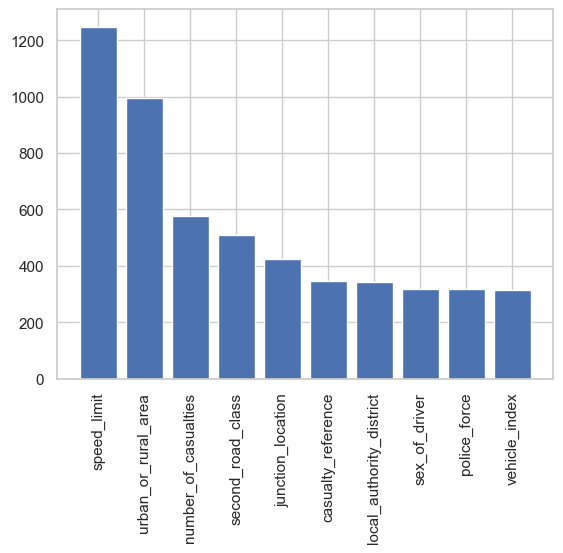

In [52]:
# Sort data in descending order
sorted_data = sorted(zip(scores, names), reverse=True)
sorted_scores, sorted_names = zip(*sorted_data)

plt.bar(sorted_names, sorted_scores)
plt.xticks(rotation='vertical')
plt.show()

In [53]:
#use the best top five selected features excluding number_of_casualties
apr = num_data[['accident_severity','urban_or_rural_area', 'speed_limit', 'second_road_class', 'junction_location']]
apr

accident_severity  urban_or_rural_area  speed_limit  \
0                       2                    1         20.0   
1                       2                    1         20.0   
2                       2                    1         20.0   
3                       2                    1         30.0   
4                       2                    1         30.0   
...                   ...                  ...          ...   
220430                  2                    2         60.0   
220431                  2                    2         60.0   
220432                  2                    1         30.0   
220433                  2                    1         30.0   
220434                  2                    1         30.0   

        second_road_class  junction_location  
0                     0.0                0.0  
1                     6.0                2.0  
2                     6.0                2.0  
3                     6.0                0.0  
4                     0.0                0.0  
...                   ...                ...  
220430                6.0                6.0  
220431                6.0                1.0  
220432                6.0                6.0  
220433                6.0                8.0  
220434                0.0                0.0  

[220435 rows x 5 columns]

<AxesSubplot:>

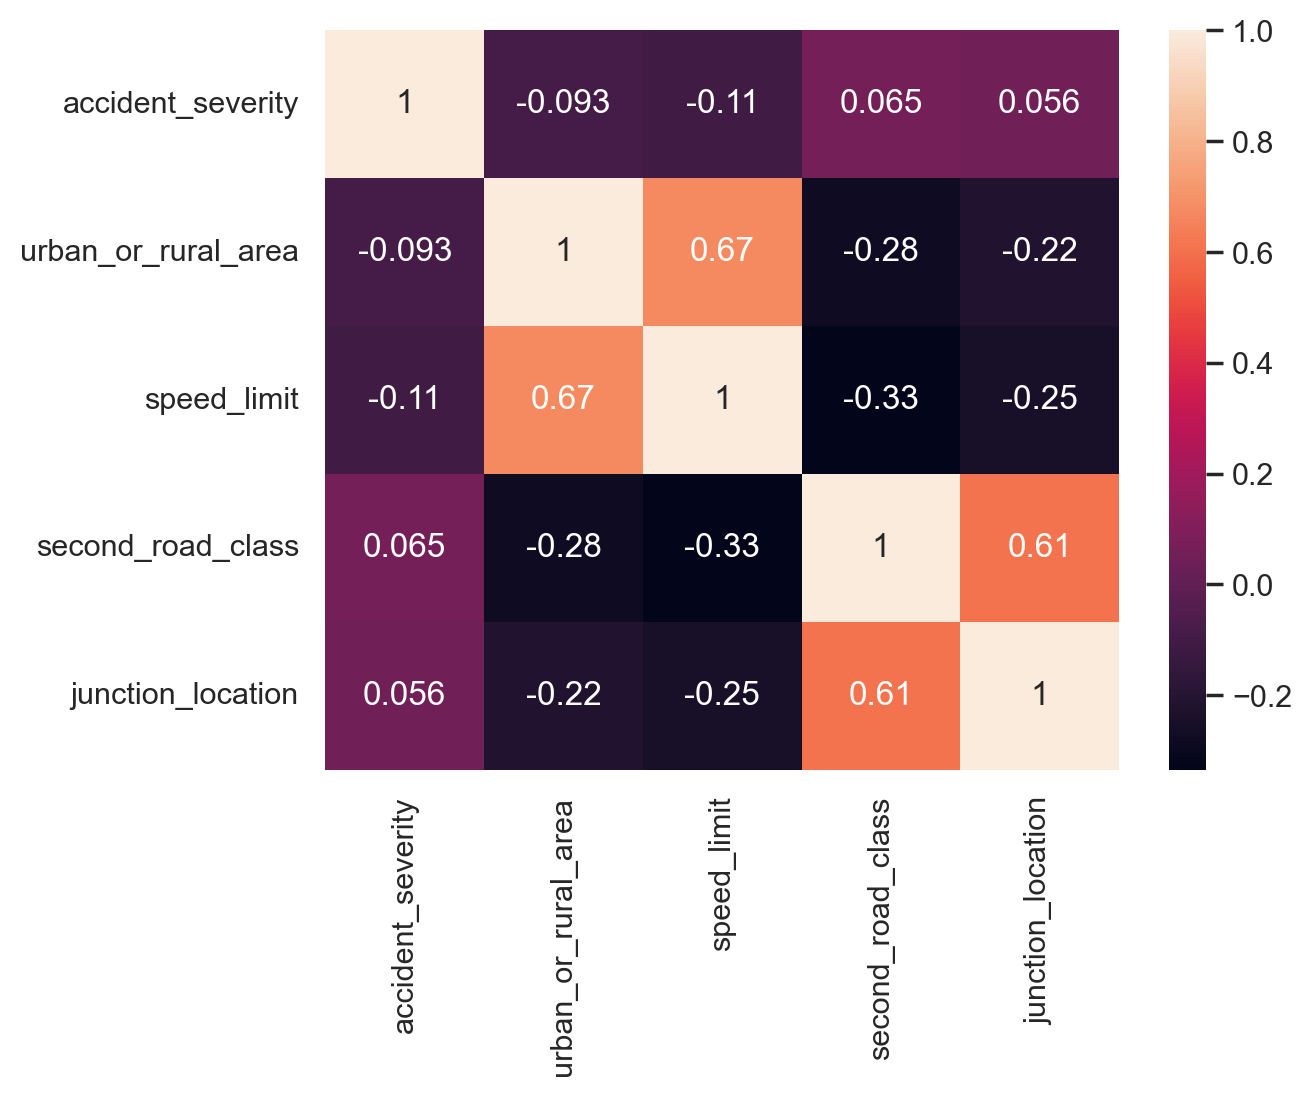

In [54]:
plt.figure(dpi=200)
sns.heatmap(apr.corr(), annot = True)

In [55]:
#convert variables to one hot encoding
def dummy_variables(df, categorical_features):
    dummies = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)  # Assuming 'categorical_features' is a list of column names
    return dummies

# List of categorical column names
categorical_features = ['accident_severity','urban_or_rural_area', 'speed_limit', 'second_road_class', 'junction_location']  

meg_all = dummy_variables(apr, categorical_features)
meg_all

accident_severity_1  accident_severity_2  urban_or_rural_area_1  \
0                         0                    1                      1   
1                         0                    1                      1   
2                         0                    1                      1   
3                         0                    1                      1   
4                         0                    1                      1   
...                     ...                  ...                    ...   
220430                    0                    1                      0   
220431                    0                    1                      0   
220432                    0                    1                      1   
220433                    0                    1                      1   
220434                    0                    1                      1   

        urban_or_rural_area_2  urban_or_rural_area_3  speed_limit_20.0  \
0                           0                      0                 1   
1                           0                      0                 1   
2                           0                      0                 1   
3                           0                      0                 0   
4                           0                      0                 0   
...                       ...                    ...               ...   
220430                      1                      0                 0   
220431                      1                      0                 0   
220432                      0                      0                 0   
220433                      0                      0                 0   
220434                      0                      0                 0   

        speed_limit_30.0  speed_limit_40.0  speed_limit_50.0  \
0                      0                 0                 0   
1                      0                 0                 0   
2                      0                 0                 0   
3                      1                 0                 0   
4                      1                 0                 0   
...                  ...               ...               ...   
220430                 0                 0                 0   
220431                 0                 0                 0   
220432                 1                 0                 0   
220433                 1                 0                 0   
220434                 1                 0                 0   

        speed_limit_60.0  ...  junction_location_0.0  junction_location_1.0  \
0                      0  ...                      1                      0   
1                      0  ...                      0                      0   
2                      0  ...                      0                      0   
3                      0  ...                      1                      0   
4                      0  ...                      1                      0   
...                  ...  ...                    ...                    ...   
220430                 1  ...                      0                      0   
220431                 1  ...                      0                      1   
220432                 0  ...                      0                      0   
220433                 0  ...                      0                      0   
220434                 0  ...                      1                      0   

        junction_location_2.0  junction_location_3.0  junction_location_4.0  \
0                           0                      0                      0   
1                           1                      0                      0   
2                           1                      0                      0   
3                           0                      0                      0   
4                           0                      0                      0   
...                       

In [56]:
#set minimum support threshold to 20%
frequent_items = apriori(meg_all, min_support = 0.2, use_colnames = True)
frequent_items

C:\Users\SPECTRE\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0   0.980806                              (accident_severity_2)
1   0.642634                            (urban_or_rural_area_1)
2   0.357212                            (urban_or_rural_area_2)
3   0.542663                                 (speed_limit_30.0)
4   0.422378                            (second_road_class_0.0)
5   0.395958                            (second_road_class_6.0)
6   0.423481                            (junction_location_0.0)
7   0.217665                            (junction_location_1.0)
8   0.636446       (accident_severity_2, urban_or_rural_area_1)
9   0.344206       (accident_severity_2, urban_or_rural_area_2)
10  0.537360            (accident_severity_2, speed_limit_30.0)
11  0.409377       (accident_severity_2, second_road_class_0.0)
12  0.391476       (accident_severity_2, second_road_class_6.0)
13  0.410475       (accident_severity_2, junction_location_0.0)
14  0.215038       (accident_severity_2, junction_location_1.0)
15  0.464745          (urban_or_rural_area_1, speed_limit_30.0)
16  0.206111     (urban_or_rural_area_1, second_road_class_0.0)
17  0.308658     (second_road_class_6.0, urban_or_rural_area_1)
18  0.207045     (urban_or_rural_area_1, junction_location_0.0)
19  0.216222     (urban_or_rural_area_2, second_road_class_0.0)
20  0.216390     (urban_or_rural_area_2, junction_location_0.0)
21  0.263729          (second_road_class_6.0, speed_limit_30.0)
22  0.420877     (second_road_class_0.0, junction_location_0.0)
23  0.460335  (accident_severity_2, urban_or_rural_area_1, s...
24  0.203062  (accident_severity_2, urban_or_rural_area_1, s...
25  0.306322  (accident_severity_2, urban_or_rural_area_1, s...
26  0.203997  (accident_severity_2, urban_or_rural_area_1, j...
27  0.206269  (accident_severity_2, second_road_class_0.0, u...
28  0.206433  (accident_severity_2, urban_or_rural_area_2, j...
29  0.261601  (accident_severity_2, speed_limit_30.0, second...
30  0.407889  (accident_severity_2, second_road_class_0.0, j...
31  0.234654  (second_road_class_6.0, urban_or_rural_area_1,...
32  0.205276  (urban_or_rural_area_1, second_road_class_0.0,...
33  0.215556  (urban_or_rural_area_2, second_road_class_0.0,...
34  0.232835  (accident_severity_2, urban_or_rural_area_1, s...
35  0.202227  (accident_severity_2, urban_or_rural_area_1, s...
36  0.205616  (accident_severity_2, second_road_class_0.0, u...

In [57]:
#minimum threshold of 50%
ass_rules = association_rules(frequent_items, metric = 'confidence', min_threshold = .5)
ass_rules

antecedents  \
0                            (accident_severity_2)   
1                          (urban_or_rural_area_1)   
2                          (urban_or_rural_area_2)   
3                            (accident_severity_2)   
4                               (speed_limit_30.0)   
..                                             ...   
76    (accident_severity_2, urban_or_rural_area_2)   
77    (accident_severity_2, junction_location_0.0)   
78  (urban_or_rural_area_2, second_road_class_0.0)   
79  (urban_or_rural_area_2, junction_location_0.0)   
80                         (urban_or_rural_area_2)   

                                          consequents  antecedent support  \
0                             (urban_or_rural_area_1)            0.980806   
1                               (accident_severity_2)            0.642634   
2                               (accident_severity_2)            0.357212   
3                                  (speed_limit_30.0)            0.980806   
4                               (accident_severity_2)            0.542663   
..                                                ...                 ...   
76     (second_road_class_0.0, junction_location_0.0)            0.344206   
77     (urban_or_rural_area_2, second_road_class_0.0)            0.410475   
78       (accident_severity_2, junction_location_0.0)            0.216222   
79       (accident_severity_2, second_road_class_0.0)            0.216390   
80  (accident_severity_2, second_road_class_0.0, j...            0.357212   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.642634  0.636446    0.648901  1.009752  0.006147    1.017850   
1             0.980806  0.636446    0.990371  1.009752  0.006147    1.993390   
2             0.980806  0.344206    0.963590  0.982447 -0.006150    0.527159   
3             0.542663  0.537360    0.547876  1.009606  0.005113    1.011529   
4             0.980806  0.537360    0.990228  1.009606  0.005113    1.964079   
..                 ...       ...         ...       ...       ...         ...   
76            0.420877  0.205616    0.597364  1.419332  0.060748    1.438329   
77            0.216222  0.205616    0.500923  2.316701  0.116862    1.570454   
78            0.410475  0.205616    0.950947  2.316701  0.116862   12.018196   
79            0.409377  0.205616    0.950210  2.321112  0.117031   11.862198   
80            0.407889  0.205616    0.575614  1.411203  0.059913    1.395218   

    zhangs_metric  
0        0.503187  
1        0.027026  
2       -0.027044  
3        0.495700  
4        0.020804  
..            ...  
76       0.450512  
77       0.964084  
78       0.725144  
79       0.726346  
80       0.453314  

[81 rows x 10 columns]

In [58]:
#minimum threshold of 100%
ass_rules_lift = association_rules(frequent_items, metric = 'lift', min_threshold = 1)
ass_rules_lift

antecedents  \
0                             (accident_severity_2)   
1                           (urban_or_rural_area_1)   
2                             (accident_severity_2)   
3                                (speed_limit_30.0)   
4                             (accident_severity_2)   
..                                              ...   
101  (second_road_class_0.0, junction_location_0.0)   
102  (urban_or_rural_area_2, junction_location_0.0)   
103                         (second_road_class_0.0)   
104                         (urban_or_rural_area_2)   
105                         (junction_location_0.0)   

                                           consequents  antecedent support  \
0                              (urban_or_rural_area_1)            0.980806   
1                                (accident_severity_2)            0.642634   
2                                   (speed_limit_30.0)            0.980806   
3                                (accident_severity_2)            0.542663   
4                              (second_road_class_6.0)            0.980806   
..                                                 ...                 ...   
101       (accident_severity_2, urban_or_rural_area_2)            0.420877   
102       (accident_severity_2, second_road_class_0.0)            0.216390   
103  (accident_severity_2, junction_location_0.0, u...            0.422378   
104  (accident_severity_2, second_road_class_0.0, j...            0.357212   
105  (accident_severity_2, second_road_class_0.0, u...            0.423481   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.642634  0.636446    0.648901  1.009752  0.006147    1.017850   
1              0.980806  0.636446    0.990371  1.009752  0.006147    1.993390   
2              0.542663  0.537360    0.547876  1.009606  0.005113    1.011529   
3              0.980806  0.537360    0.990228  1.009606  0.005113    1.964079   
4              0.395958  0.391476    0.399137  1.008028  0.003118    1.005291   
..                  ...       ...         ...       ...       ...         ...   
101            0.344206  0.205616    0.488542  1.419332  0.060748    1.282206   
102            0.409377  0.205616    0.950210  2.321112  0.117031   11.862198   
103            0.206433  0.205616    0.486806  2.358180  0.118423    1.546328   
104            0.407889  0.205616    0.575614  1.411203  0.059913    1.395218   
105            0.206269  0.205616    0.485538  2.353903  0.118265    1.542837   

     zhangs_metric  
0         0.503187  
1         0.027026  
2         0.495700  
3         0.020804  
4         0.414951  
..             ...  
101       0.510156  
102       0.726346  
103       0.997096  
104       0.453314  
105       0.997666  

[106 rows x 10 columns]

In [59]:
#accident_severity_1 as fatal accident
fatal_casualty = ass_rules[ass_rules['consequents'] == {'accident_severity_1'}]

fatal_casualty

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

In [60]:
#accident_severity_2 as non_fatal accident
serious_casualty = ass_rules[ass_rules['consequents'] == {'accident_severity_2'}]

sorted_serious_casualty = serious_casualty.sort_values(by='confidence', ascending=False)

sorted_serious_casualty

antecedents            consequents  \
26     (second_road_class_6.0, urban_or_rural_area_1)  (accident_severity_2)   
60  (second_road_class_6.0, urban_or_rural_area_1,...  (accident_severity_2)   
38          (second_road_class_6.0, speed_limit_30.0)  (accident_severity_2)   
21          (urban_or_rural_area_1, speed_limit_30.0)  (accident_severity_2)   
1                             (urban_or_rural_area_1)  (accident_severity_2)   
4                                  (speed_limit_30.0)  (accident_severity_2)   
6                             (second_road_class_6.0)  (accident_severity_2)   
8                             (junction_location_1.0)  (accident_severity_2)   
28     (urban_or_rural_area_1, junction_location_0.0)  (accident_severity_2)   
24     (urban_or_rural_area_1, second_road_class_0.0)  (accident_severity_2)   
68  (urban_or_rural_area_1, second_road_class_0.0,...  (accident_severity_2)   
7                             (junction_location_0.0)  (accident_severity_2)   
5                             (second_road_class_0.0)  (accident_severity_2)   
42     (second_road_class_0.0, junction_location_0.0)  (accident_severity_2)   
2                             (urban_or_rural_area_2)  (accident_severity_2)   
35     (urban_or_rural_area_2, junction_location_0.0)  (accident_severity_2)   
31     (urban_or_rural_area_2, second_road_class_0.0)  (accident_severity_2)   
74  (urban_or_rural_area_2, second_road_class_0.0,...  (accident_severity_2)   

    antecedent support  consequent support   support  confidence      lift  \
26            0.308658            0.980806  0.306322    0.992431  1.011852   
60            0.234654            0.980806  0.232835    0.992248  1.011665   
38            0.263729            0.980806  0.261601    0.991933  1.011344   
21            0.464745            0.980806  0.460335    0.990512  1.009896   
1             0.642634            0.980806  0.636446    0.990371  1.009752   
4             0.542663            0.980806  0.537360    0.990228  1.009606   
6             0.395958            0.980806  0.391476    0.988680  1.008028   
8             0.217665            0.980806  0.215038    0.987933  1.007266   
28            0.207045            0.980806  0.203997    0.985276  1.004557   
24            0.206111            0.980806  0.203062    0.985209  1.004489   
68            0.205276            0.980806  0.202227    0.985149  1.004428   
7             0.423481            0.980806  0.410475    0.969288  0.988256   
5             0.422378            0.980806  0.409377    0.969218  0.988185   
42            0.420877            0.980806  0.407889    0.969141  0.988106   
2             0.357212            0.980806  0.344206    0.963590  0.982447   
35            0.216390            0.980806  0.206433    0.953983  0.972652   
31            0.216222            0.980806  0.206269    0.953968  0.972637   
74            0.215556            0.980806  0.205616    0.953889  0.972556   

    leverage  conviction  zhangs_metric  
26  0.003588    2.535789       0.016943  
60  0.002685    2.475865       0.015066  
38  0.002934    2.379180       0.015235  
21  0.004511    2.022978       0.018307  
1   0.006147    1.993390       0.027026  
4   0.005113    1.964079       0.020804  
6   0.003118    1.695646       0.013185  
8   0.001551    1.590572       0.009221  
28  0.000925    1.303583       0.005721  
24  0.000908    1.297700       0.005630  
68  0.000892    1.292444       0.005547  
7  -0.004878    0.624956      -0.020196  
5  -0.004894    0.623546      -0.020279  
42 -0.004910    0.621981      -0.020361  
2  -0.006150    0.527159      -0.027044  
35 -0.005804    0.417106      -0.034638  
31 -0.005803    0.416972      -0.034650  
74 -0.005802    0.416255      -0.034723

# Clustering: Identify Accident Regions

In [61]:
#join accident and lsoa table for this task and filter where ploice_force is 16 to select regions of interest(Humberside)
sql_query = '''
    SELECT accident_index, longitude, latitude, lsoa01nm, lsoa01cd, police_force
    FROM accident AS a
    JOIN lsoa AS l
    ON
    a.lsoa_of_accident_location = l.lsoa01cd
    WHERE a.police_force == 16 AND accident_year == 2020
'''
# Execute the SQL query
cursor.execute(sql_query)

# Fetch all the rows from the query result
rows = cursor.fetchall()

# Retrieve the column names from the cursor's description
columns = [column[0] for column in cursor.description]

# Put the fetched rows in a DataFrame with the column names
acc_region = pd.DataFrame(rows, columns=columns)

# Output the DataFrame
acc_region.head(10)

accident_index  longitude   latitude                       lsoa01nm  \
0  2020160914930  -0.393424  53.744936        Kingston upon Hull 028E   
1  2020160915008  -0.528743  53.512895        North Lincolnshire 022C   
2  2020160915028  -0.324858  53.791630        Kingston upon Hull 002E   
3  2020160915041  -0.095008  53.574501   North East Lincolnshire 003C   
4  2020160915047  -0.327733  53.767805        Kingston upon Hull 016D   
5  2020160915311  -0.078215  53.553782   North East Lincolnshire 016C   
6  2020160915332  -0.309102  53.750410        Kingston upon Hull 026D   
7  2020160915337  -0.335481  53.777540        Kingston upon Hull 016D   
8  2020160915489  -0.832277  53.609396        North Lincolnshire 006D   
9  2020160915561  -0.335628  53.859763  East Riding of Yorkshire 014A   

    lsoa01cd  police_force  
0  E01012777            16  
1  E01013325            16  
2  E01012788            16  
3  E01013220            16  
4  E01012817            16  
5  E01013183            16  
6  E01012810            16  
7  E01012817            16  
8  E01013248            16  
9  E01012924            16

In [62]:
acc_region.shape

(1663, 6)

In [63]:
acc_region.isna().sum()

accident_index    0
longitude         0
latitude          0
lsoa01nm          0
lsoa01cd          0
police_force      0
dtype: int64

In [64]:
acc_region.isin([-1]).sum()

accident_index    0
longitude         0
latitude          0
lsoa01nm          0
lsoa01cd          0
police_force      0
dtype: int64

In [65]:
# name list of entries as 'acc_entries'
acc_entries = acc_region['lsoa01nm']

# Extract only the unique names without the last code
unique_names = list(set(entry[:-5] if entry[-5] == ' ' else entry for entry in acc_entries))

# Print out the unique entry in a list
print(unique_names)

['North East Lincolnshire', 'North Lincolnshire', 'Kingston upon Hull', 'East Riding of Yorkshire']


In [66]:
# Extract only the unique names without the last code
unique_names = [entry[:-5] if entry[-5] == ' ' else entry for entry in acc_entries]

# Convert the list to a pandas Series
name_series = pd.Series(unique_names)

# Use value_counts() to get the count of each unique name
name_counts = name_series.value_counts()

print(name_counts)

Kingston upon Hull          569
East Riding of Yorkshire    488
North Lincolnshire          304
North East Lincolnshire     302
dtype: int64


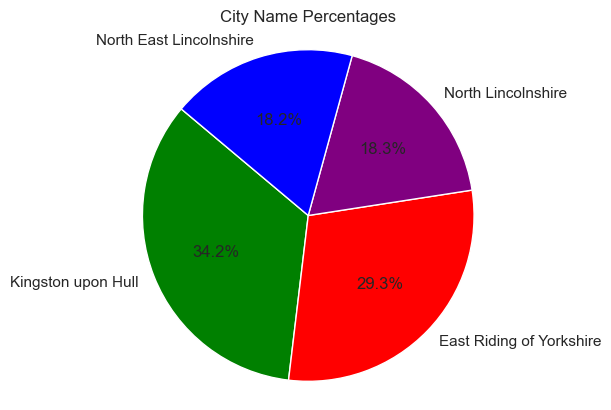

In [67]:
# Sort the name_counts Series in descending order
name_counts_sorted = name_counts.sort_values(ascending=False)

# Calculate the total count
total_count = name_counts_sorted.sum()

# Calculate the percentages
percentages = (name_counts_sorted / total_count) * 100

# Create a pie chart using matplotlib with custom colors for each slice
colors = ['green', 'red', 'purple', 'blue']
plt.pie(percentages, labels=name_counts_sorted.index, colors=colors, autopct='%.1f%%', startangle=140)

# Add title
plt.title('City Name Percentages')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

In [68]:
#extract latitude and longitude from acc_region
reg = acc_region[['longitude', 'latitude']]
reg.head()

longitude   latitude
0  -0.393424  53.744936
1  -0.528743  53.512895
2  -0.324858  53.791630
3  -0.095008  53.574501
4  -0.327733  53.767805

In [69]:
reg.isna().sum()

longitude    0
latitude     0
dtype: int64

In [70]:
reg.isin([-1]).sum()

longitude    0
latitude     0
dtype: int64

In [71]:
sample_size = reg.shape[0]
reg_sample = reg.sample(n=sample_size, random_state=42)

# Verify the shape of the sampled DataFrame
reg_sample.shape

(1663, 2)

In [72]:
#scale the region
reg_scaled = StandardScaler().fit_transform(reg)
reg_scaled

array([[-0.04961134,  0.19077661],
       [-0.65924685, -1.49961163],
       [ 0.25929036,  0.53093627],
       ...,
       [ 0.33127401,  0.46624664],
       [-1.44512022, -1.08505889],
       [ 0.18177886,  0.17382472]])

# Using K-means Clustering

In [73]:
# Perform K-Means clustering with 5 clusters
Z = np.array(list(zip(acc_region['longitude'], acc_region['latitude'])))
kmeans = KMeans(n_clusters = 5, random_state=42)
labels = kmeans.fit_predict(Z)
centroids = kmeans.cluster_centers_

# Calculate Silhouette Score
km_sil_avg = silhouette_score(Z, labels)

print(f"K-Means Silhouette Score: {km_sil_avg}")

K-Means Silhouette Score: 0.622095314133076


In [74]:
km_sil = pd.DataFrame(['K-Means', km_sil_avg]).transpose()
km_sil.columns = ['Cluster Method', 'Silhouette Score']

km_sil

Cluster Method Silhouette Score
0        K-Means         0.622095

In [75]:
# List of colors for each cluster
cluster_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(5)]

# Create a folium map centered around the mean latitude and longitude
map_center = [acc_region['latitude'].mean(), acc_region['longitude'].mean()]
create_map = folium.Map(location=map_center, zoom_start=10)

# Add the clustered points to the map
for lat, lon, cluster_label in zip(acc_region['latitude'], acc_region['longitude'], labels):
    color = cluster_colors[cluster_label]
    folium.CircleMarker(location=[lat, lon], radius=3, color=color, fill=True, fill_opacity=0.7).add_to(create_map)

# Add cluster centroids to the map
for centroid, color in zip(centroids, cluster_colors):
    folium.Marker(location=[centroid[1], centroid[0]], icon=folium.Icon(color=color)).add_to(create_map)

# Add Silhouette Score to the map
silhouette_text = f"Silhouette Score: {km_sil_avg:.2f}"
folium.map.Marker([acc_region['latitude'].mean(), acc_region['longitude'].mean()],
                  icon=DivIcon(html=f'<div>{silhouette_text}</div>')).add_to(create_map)

# Display the map
create_map

#Reference: https://python-visualization.github.io/folium/
            #https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20

# Using Agglomerative Clustering

In [76]:
# Perform Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=5)  # Set the number of clusters as needed
labels = agglomerative.fit_predict(Z)

# Calculate silhouette score (only for clusters with more than 1 cluster)
if len(set(labels)) > 1:
    agg_sil_avg = silhouette_score(Z, labels)
    print(f"Silhouette Score for Agglomerative Clustering: {agg_sil_avg}")
else:
    print("Insufficient clusters for silhouette score calculation.")

Silhouette Score for Agglomerative Clustering: 0.5917666534115661


In [77]:
agg_sil = pd.DataFrame(['Agglomerative', agg_sil_avg]).transpose()
agg_sil.columns = ['Cluster Method', 'Silhouette Score']

agg_sil

Cluster Method Silhouette Score
0  Agglomerative         0.591767

In [78]:
# Create a folium map
create_map = folium.Map(location=[acc_region['latitude'].mean(), acc_region['longitude'].mean()], zoom_start=10)

# Define a list of colors for each cluster
unique_labels = set(labels)
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(unique_labels))]

# Add clustered points to the map
for lat, lon, label in zip(acc_region['latitude'], acc_region['longitude'], labels):
    color = colors[label]
    folium.CircleMarker(location=[lat, lon], radius=3, color=color, fill=True, fill_opacity=0.7).add_to(create_map)

# Display the map
create_map


# Using KMedoids Clustering

In [79]:
# Perform k-medoids clustering with 5 clusters
kmedoids = KMedoids(n_clusters=5, random_state=42)
labels = kmedoids.fit_predict(Z)
medoids = Z[kmedoids.medoid_indices_]

# Calculate silhouette score
KMed_sil_avg = silhouette_score(Z, labels)
print(f"Silhouette Score for KMedoid: {KMed_sil_avg}")


Silhouette Score for KMedoid: 0.43422208419852754


In [80]:
KMed_sil = pd.DataFrame(['KMedoids', KMed_sil_avg]).transpose()
KMed_sil.columns = ['Cluster Method', 'Silhouette Score']

KMed_sil

Cluster Method Silhouette Score
0       KMedoids         0.434222

In [81]:
# Create a folium map
create_map = folium.Map(location=[acc_region['latitude'].mean(), acc_region['longitude'].mean()], zoom_start=10)

# Define a list of colors for each cluster
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']

# Add clustered points to the map
for lat, lon, cluster_label in zip(acc_region['latitude'], acc_region['longitude'], labels):
    color = cluster_colors[cluster_label]
    folium.CircleMarker(location=[lat, lon], radius=3, color=color, fill=True, fill_opacity=0.7).add_to(create_map)

# Add medoids to the map
for medoid, color in zip(medoids, cluster_colors):
    lat, lon = medoid
    folium.Marker(location=[lat, lon], icon=folium.Icon(color=color)).add_to(create_map)

# Display the map
create_map

# Using DBSCAN clustering

In [82]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(Z)

# Calculate silhouette score (only for clusters with more than 1 cluster)
if len(set(labels)) > 1:
    db_sil_avg = silhouette_score(Z, labels)
    print(f"Silhouette Score for DBSCAN: {db_sil_avg}")
else:
    print("Insufficient clusters for silhouette score calculation.")

Silhouette Score for DBSCAN: 0.3375813117972325


In [83]:
db_sil = pd.DataFrame(['DBSCAN', db_sil_avg]).transpose()
db_sil.columns = ['Cluster Method', 'Silhouette Score']

db_sil

Cluster Method Silhouette Score
0         DBSCAN         0.337581

In [84]:
# Create a folium map
create_map = folium.Map(location=[acc_region['latitude'].mean(), acc_region['longitude'].mean()], zoom_start=10)

# Define a list of colors for each cluster
unique_labels = set(labels)
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(unique_labels))]

# Add clustered points to the map
for lat, lon, label in zip(acc_region['latitude'], acc_region['longitude'], labels):
    color = colors[label]
    folium.CircleMarker(location=[lat, lon], radius=3, color=color, fill=True, fill_opacity=0.7).add_to(create_map)

# Display the map
create_map

In [85]:
#concat the silhouette scores for all four types of clusters
concat_clut = pd.concat([km_sil, agg_sil, KMed_sil, db_sil])
concat_clut

Cluster Method Silhouette Score
0        K-Means         0.622095
0  Agglomerative         0.591767
0       KMedoids         0.434222
0         DBSCAN         0.337581

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


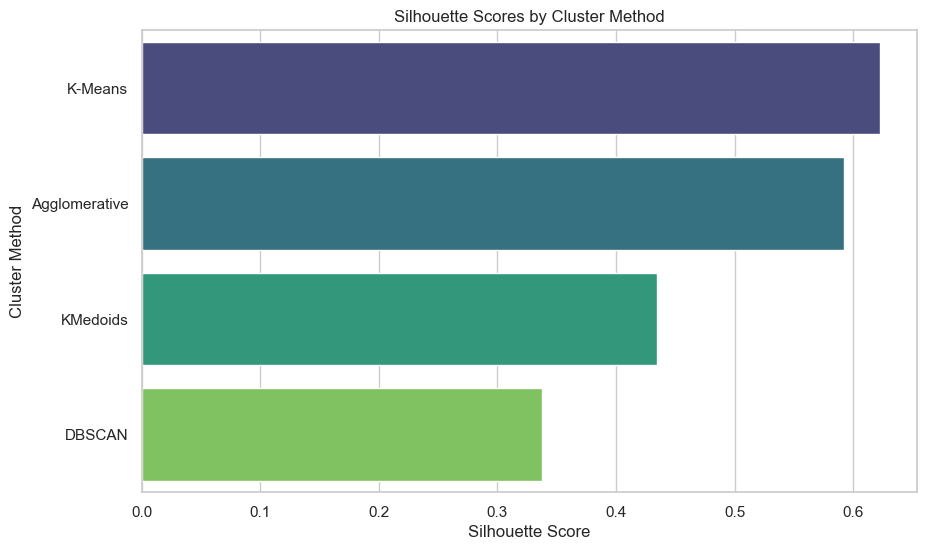

In [86]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Extract cluster methods and silhouette scores
cluster_methods = concat_clut['Cluster Method']
silhouette_scores = concat_clut['Silhouette Score']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=silhouette_scores, y=cluster_methods, palette="viridis")
plt.xlabel('Silhouette Score')
plt.ylabel('Cluster Method')
plt.title('Silhouette Scores by Cluster Method')
plt.show()


# Detect Outliers

In [87]:
num_data

accident_year  location_easting_osgr  location_northing_osgr  \
0                2020              -0.254001               51.462262   
1                2020              -0.139253               51.470327   
2                2020              -0.139253               51.470327   
3                2020              -0.178719               51.529614   
4                2020              -0.001683               51.541210   
...               ...                    ...                     ...   
220430           2020              -2.271903               57.186317   
220431           2020              -2.271903               57.186317   
220432           2020              -3.968753               55.950940   
220433           2020              -3.968753               55.950940   
220434           2020              -4.561040               56.003843   

        longitude  latitude  police_force  accident_severity  \
0        175144.0  521389.0             1                  2   
1        176237.0  529337.0             1                  2   
2        176237.0  529337.0             1                  2   
3        182761.0  526432.0             1                  2   
4        184371.0  538676.0             1                  2   
...           ...       ...           ...                ...   
220430   810646.0  383664.0            99                  2   
220431   810646.0  383664.0            99                  2   
220432   674852.0  277161.0            99                  2   
220433   674852.0  277161.0            99                  2   
220434   681950.0  240402.0            99                  2   

        number_of_vehicles  number_of_casualties  day_of_week  ...  \
0                        1                     1            3  ...   
1                        1                     2            2  ...   
2                        1                     2            2  ...   
3                        1                     1            4  ...   
4                        1                     1            4  ...   
...                    ...                   ...          ...  ...   
220430                   2                     1            4  ...   
220431                   2                     1            4  ...   
220432                   2                     1            3  ...   
220433                   2                     1            3  ...   
220434                   1                     1            3  ...   

        age_band_of_casualty  casualty_severity  pedestrian_location  \
0                        6.0                  3                  9.0   
1                        1.0                  3                  1.0   
2                        1.0                  3                  1.0   
3                        5.0                  3                  5.0   
4                        8.0                  2                  4.0   
...                      ...                ...                  ...   
220430                   7.0                  2                  0.0   
220431                   7.0                  2                  0.0   
220432                  11.0                  3                  0.0   
220433                  11.0                  3                  0.0   
220434                   8.0                  3                  9.0   

        pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                       5.0            0.0                     0.0   
1                       1.0            0.0                     0.0   
2                       1.0            0.0                     0.0   
3                       9.0            0.0                     0.0   
4                       1.0            0.0                     0.0   
...                     ...            ...                     ...   
220430                  0.0            0.0                     0.0   
220431                  0.0            0.0                     0.0   
220432                  0.0           

In [88]:
#variables to test outliers on
outlier_feat = num_data[['longitude','latitude', 'age_of_vehicle', 'age_of_driver', 'age_of_casualty']]

Outlier Counts:  1    219886
-1       549
dtype: int64


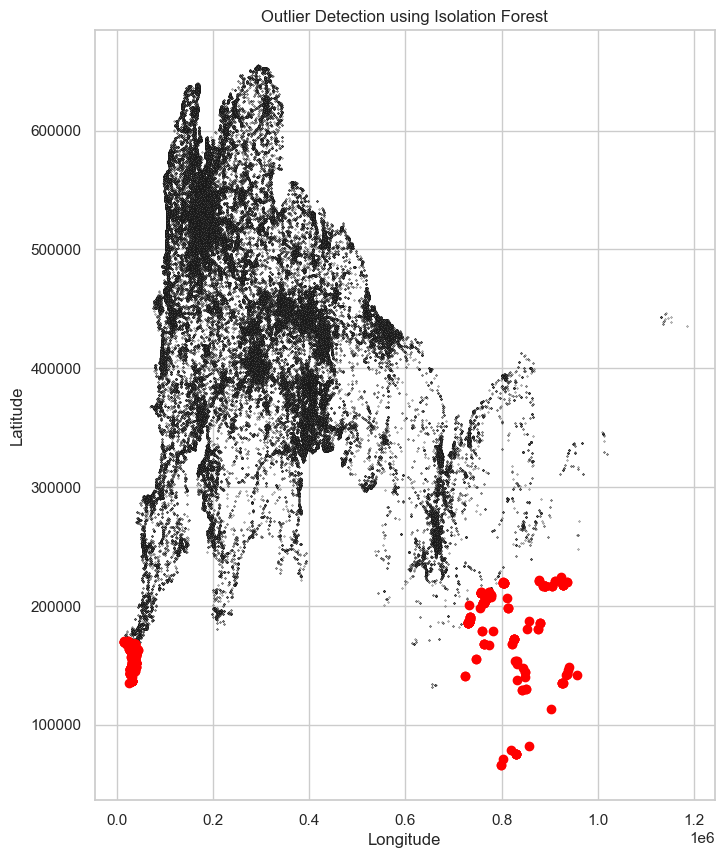

In [89]:
#using isolation forest method to detect outlier on longitude and latitude

# Selecting the features for outlier detection
area = outlier_feat[['longitude', 'latitude']]
contamination_levels = [0.0025, 0.05]

# Create the Isolation Forest model
model_if = IsolationForest(contamination=contamination_levels[0], random_state=42)

# Fit the model and predict outliers
y_pred = model_if.fit_predict(area)

# Convert the predictions to binary form
IF_anomalies = area[y_pred == -1]

# Display the count of outliers
outlier_counts = pd.Series(y_pred).value_counts()
print("Outlier Counts:", outlier_counts)

# Create a scatter plot to visualize outliers
plt.figure(figsize=(8, 10))
plt.scatter(area['longitude'], area['latitude'], c='white', s=0.09, edgecolors='k')
plt.scatter(IF_anomalies['longitude'], IF_anomalies['latitude'], c='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Outlier Detection using Isolation Forest')
plt.show()

In [90]:
#using IQR detection Method
#define iqr_test function
def iqr_test(df, column_name):
    column_data = df[column_name]
    q1 = column_data.quantile(0.25)
    q3 = column_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]
    return outliers

In [91]:
# outlier detection on age_of_vehicle
vehAge_outl = iqr_test(outlier_feat, 'age_of_vehicle')

unique_vehAge_outl = vehAge_outl.unique().tolist()
print(unique_vehAge_outl)

[22.0, 28.0, 32.0, 24.0, 25.0, 23.0, 27.0, 30.0, 26.0, 29.0, 31.0, 34.0, 37.0, 44.0, 39.0, 57.0, 38.0, 51.0, 54.0, 33.0, 62.0, 46.0, 43.0, 41.0, 48.0, 45.0, 36.0, 58.0, 60.0, 64.0, 86.0, 50.0, 61.0, 53.0, 35.0, 55.0, 49.0, 92.0, 88.0, 42.0, 67.0, 84.0, 40.0, 52.0, 66.0, 56.0, 78.0, 47.0, 96.0, 68.0, 63.0, 93.0]


In [92]:
len(vehAge_outl)

1865

In [93]:
# outlier detection on age_of_driver
driAge_outl = iqr_test(outlier_feat,  'age_of_driver')

unique_driAge_outl = driAge_outl.unique().tolist()
print(unique_driAge_outl)

[81.0, 88.0, 80.0, 85.0, 87.0, 83.0, 82.0, 86.0, 90.0, 91.0, 84.0, 89.0, 93.0, 94.0, 92.0, 97.0, 95.0, 98.0, 100.0, 99.0, 96.0]


In [94]:
len(driAge_outl)

3509

In [95]:
# outlier detection on age_of_driver
casAge_outl = iqr_test(outlier_feat,  'age_of_casualty')

unique_casAge_outl = casAge_outl.unique().tolist()
print(unique_casAge_outl)

[91.0, 92.0, 94.0, 90.0, 93.0, 96.0, 95.0, 98.0, 99.0, 97.0]


In [96]:
len(casAge_outl)

497

# Classification

In [97]:
#calling x_bal and y_bal variable that was defined while running apriori
x_bal

accident_year  location_easting_osgr  location_northing_osgr  \
37               2020               0.207510               51.593297   
166              2020              -0.430454               51.441583   
184              2020              -0.420010               51.548632   
185              2020              -0.420010               51.548632   
715              2020              -0.070962               51.473359   
...               ...                    ...                     ...   
100948           2020              -1.949650               52.469889   
84592            2020              -1.510125               53.336070   
157638           2020              -1.395232               50.900375   
6818             2020              -0.044223               51.664621   
147710           2020               0.956413               51.943261   

        longitude  latitude  police_force  number_of_vehicles  \
37       190580.0  553007.0             1                   1   
166      172567.0  509181.0             1                   1   
184      184487.0  509650.0             1                   2   
185      184487.0  509650.0             1                   2   
715      176697.0  534071.0             1                   1   
...           ...       ...           ...                 ...   
100948   285772.0  403517.0            20                   3   
84592    382239.0  432718.0            14                   2   
157638   111386.0  442624.0            44                   2   
6818     198015.0  535359.0             1                   2   
147710   231323.0  603295.0            42                   2   

        number_of_casualties  day_of_week  local_authority_district  ...  \
37                         1            4                      15.0  ...   
166                        1            5                      25.0  ...   
184                        1            6                      26.0  ...   
185                        1            6                      26.0  ...   
715                        1            4                       8.0  ...   
...                      ...          ...                       ...  ...   
100948                     3            2                     300.0  ...   
84592                      2            2                     215.0  ...   
157638                     1            4                     500.0  ...   
6818                       1            6                      32.0  ...   
147710                     4            7                     455.0  ...   

        age_of_casualty  age_band_of_casualty  pedestrian_location  \
37                 29.0                   6.0                  0.0   
166                19.0                   4.0                  0.0   
184                46.0                   8.0                  0.0   
185                46.0                   8.0                  0.0   
715                45.0                   7.0                  5.0   
...                 ...                   ...                  ...   
100948             36.0                   7.0                  0.0   
84592              51.0                   8.0                  0.0   
157638             24.0                   5.0                  0.0   
6818               50.0                   8.0                  0.0   
147710             39.0                   7.0                  0.0   

        pedestrian_movement  car_passenger  bus_or_coach_passenger  \
37                      0.0            0.0                     0.0   
166                     0.0            0.0                     0.0   
184                     0.0            0.0                     0.0   
185                     0.0            0.0                     0.0   
715                     1.0            0.0                     0.0   
...                     ...            ...                     ...   
100948                  0.0            0.0                     0.0   
84592                   0.0            0.0      

In [98]:
y_bal

37        1
166       1
184       1
185       1
715       1
         ..
100948    2
84592     2
157638    2
6818      2
147710    2
Name: accident_severity, Length: 8462, dtype: int64

In [99]:
X = x_bal
y = y_bal

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using Random Forest Classifier

In [101]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_scaled,y_train)

rf_pred = rf_classifier.predict(X_test_scaled)

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           1       0.84      0.89      0.86       838
           2       0.89      0.83      0.86       855

    accuracy                           0.86      1693
   macro avg       0.86      0.86      0.86      1693
weighted avg       0.86      0.86      0.86      1693



Text(0.5, 1.0, 'Confusion Matrix for Random forest')

<Figure size 2000x3000 with 0 Axes>

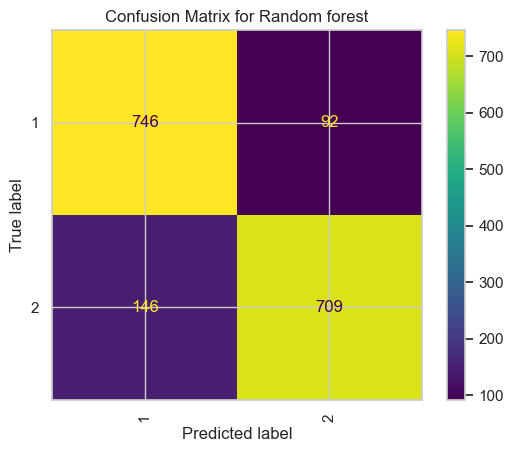

In [102]:
# Plot the confusion matrix for Casualty Severity
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,rf_pred)

# Rotate x-axis
plt.xticks(rotation=90)

# Title the plot
plt.title('Confusion Matrix for Random forest')

In [103]:
# Create variables for training and test accuracy
rf_training_accuracy = round(rf_classifier.score(X_train_scaled, y_train), 2)
rf_testing_accuracy = round(rf_classifier.score(X_test_scaled, y_test), 2)

rf_acc = pd.DataFrame(['Random Forest', rf_training_accuracy, rf_testing_accuracy]).transpose()
rf_acc.columns = ['Method', 'Training Accuracy', 'Testing Accuracy']

rf_acc

Method Training Accuracy Testing Accuracy
0  Random Forest               1.0             0.86

# Using Decision Tree

In [104]:
dt_classifier = DecisionTreeClassifier(random_state=0)

dt_classifier.fit(X_train_scaled,y_train)

dt_pred = dt_classifier.predict(X_test_scaled)

print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           1       0.77      0.85      0.80       838
           2       0.83      0.75      0.79       855

    accuracy                           0.80      1693
   macro avg       0.80      0.80      0.80      1693
weighted avg       0.80      0.80      0.80      1693



Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

<Figure size 2000x3000 with 0 Axes>

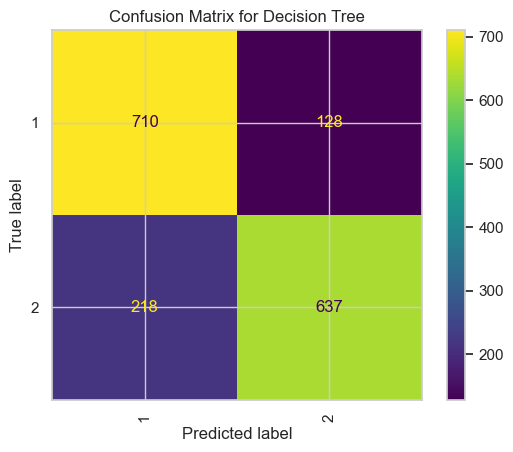

In [105]:
# Plot the confusion matrix for Casualty Severity
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,dt_pred)

# Rotate x-axis
plt.xticks(rotation=90)

# Title the plot
plt.title('Confusion Matrix for Decision Tree')

In [106]:
# Create variables for training and test accuracy
dt_training_accuracy = round(dt_classifier.score(X_train_scaled, y_train), 2)
dt_testing_accuracy = round(dt_classifier.score(X_test_scaled, y_test), 2)

dt_acc = pd.DataFrame(['Decision Tree', dt_training_accuracy, dt_testing_accuracy]).transpose()
dt_acc.columns = ['Method', 'Training Accuracy', 'Testing Accuracy']

dt_acc

Method Training Accuracy Testing Accuracy
0  Decision Tree               1.0              0.8

# Using Gradient Boosting

In [107]:
# Create a Gradient Boosting Classifier instance
gb_classifier = GradientBoostingClassifier(random_state=0)

# Fit the classifier to the training data
gb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test data
gb_pred = gb_classifier.predict(X_test_scaled)

# Print the classification report
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           1       0.79      0.80      0.80       838
           2       0.80      0.79      0.79       855

    accuracy                           0.80      1693
   macro avg       0.80      0.80      0.80      1693
weighted avg       0.80      0.80      0.80      1693



Text(0.5, 1.0, 'Confusion Matrix for Gradient Boosting')

<Figure size 2000x3000 with 0 Axes>

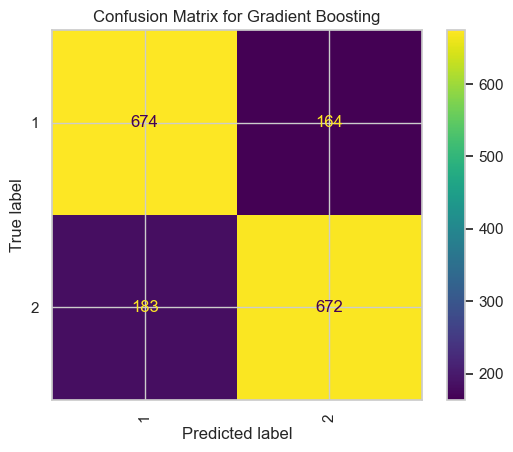

In [108]:
# Plot the confusion matrix for Casualty Severity
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,gb_pred)

# Rotate x-axis
plt.xticks(rotation=90)

# Title the plot
plt.title('Confusion Matrix for Gradient Boosting')

In [109]:
# Create variables for training and test accuracy
gb_training_accuracy = round(gb_classifier.score(X_train_scaled, y_train), 2)
gb_testing_accuracy = round(gb_classifier.score(X_test_scaled, y_test), 2)

gb_acc = pd.DataFrame(['Gradient Boosting', gb_training_accuracy, gb_testing_accuracy]).transpose()
gb_acc.columns = ['Method', 'Training Accuracy', 'Testing Accuracy']

gb_acc

Method Training Accuracy Testing Accuracy
0  Gradient Boosting              0.84              0.8

# Using K Nearest Neighbor

In [110]:
# Create a k-Nearest Neighbors Classifier instance with k=3 (you can choose a different value for k)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test data
knn_pred = knn_classifier.predict(X_test_scaled)

# Print the classification report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           1       0.71      0.82      0.76       838
           2       0.80      0.67      0.73       855

    accuracy                           0.75      1693
   macro avg       0.75      0.75      0.74      1693
weighted avg       0.75      0.75      0.74      1693



Text(0.5, 1.0, 'Confusion Matrix for K-Nearest Neighbor')

<Figure size 2000x3000 with 0 Axes>

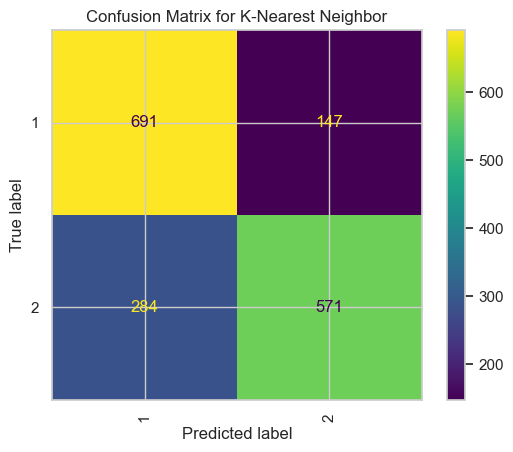

In [111]:
# Plot the confusion matrix for Casualty Severity
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,knn_pred)

# Rotate x-axis
plt.xticks(rotation=90)

# Title the plot
plt.title('Confusion Matrix for K-Nearest Neighbor')

In [112]:
# Create variables for training and test accuracy
knn_training_accuracy = round(knn_classifier.score(X_train_scaled, y_train), 2)
knn_testing_accuracy = round(knn_classifier.score(X_test_scaled, y_test), 2)

knn_acc = pd.DataFrame(['K-Nearest Neighbor', knn_training_accuracy, knn_testing_accuracy]).transpose()
knn_acc.columns = ['Method', 'Training Accuracy', 'Testing Accuracy']

knn_acc

Method Training Accuracy Testing Accuracy
0  K-Nearest Neighbor              0.88             0.75

# Compare Models

In [113]:
accuracy_comparism = pd.concat([rf_acc, dt_acc, gb_acc, knn_acc])
accuracy_comparism

Method Training Accuracy Testing Accuracy
0       Random Forest               1.0             0.86
0       Decision Tree               1.0              0.8
0   Gradient Boosting              0.84              0.8
0  K-Nearest Neighbor              0.88             0.75

C:\Users\SPECTRE\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\SPECTRE\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


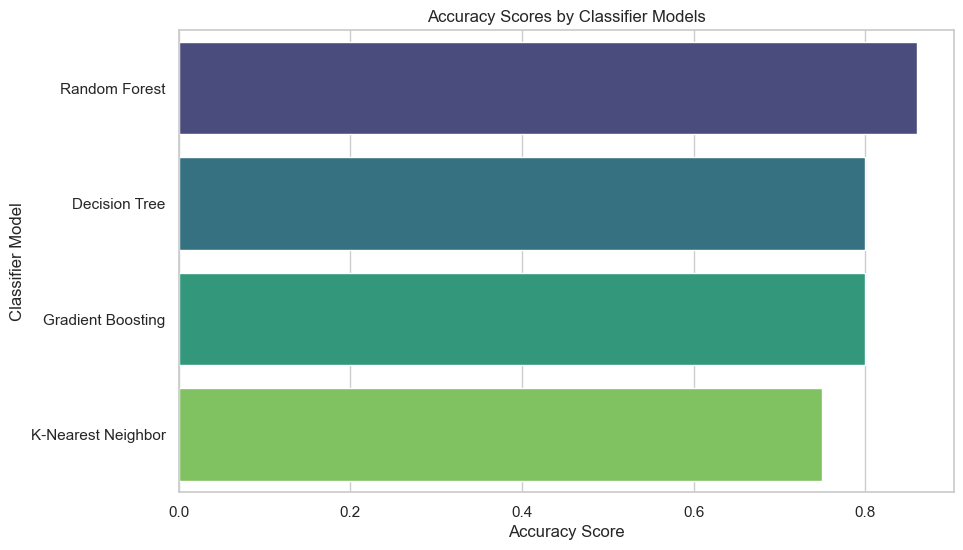

In [114]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Extract cluster methods and silhouette scores
classifier_model = accuracy_comparism['Method']
accuracy_scores = accuracy_comparism['Testing Accuracy']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_scores, y=classifier_model, palette="viridis")
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier Model')
plt.title('Accuracy Scores by Classifier Models')
plt.show()

# Feature importance on Random Forest

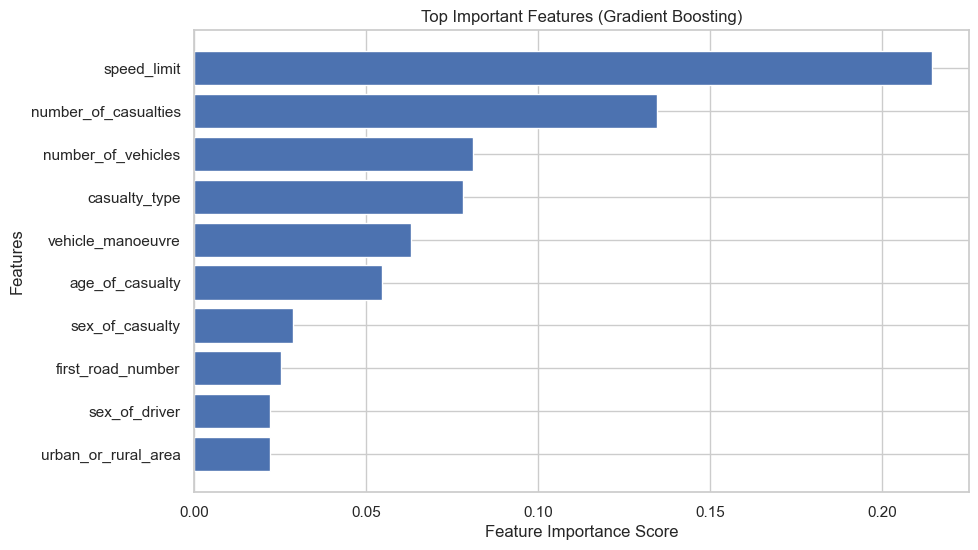

In [115]:
rf_classf = GradientBoostingClassifier()
rf_classf.fit(X_train_scaled,y_train)

# Get feature importances from the trained classifier
feature_importances = rf_classf.feature_importances_

# Sort the features and their importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [X_train.columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Display the top important features
num_top_features = 10  # Set the number of top features to display
top_features = sorted_features[:num_top_features]
top_importances = sorted_importances[:num_top_features]

# Create a bar plot for top important features
plt.figure(figsize=(10, 6))
plt.barh(range(num_top_features), top_importances, align='center')
plt.yticks(range(num_top_features), top_features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top Important Features (Gradient Boosting)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [116]:
X = x_bal[['speed_limit', 'number_of_casualties', 'number_of_vehicles', 'casualty_type','vehicle_manoeuvre', 
           'age_of_casualty', 'sex_of_casualty', 'first_road_number', 'sex_of_driver', 'urban_or_rural_area']]
y = y_bal

In [117]:
X

speed_limit  number_of_casualties  number_of_vehicles  casualty_type  \
37             50.0                     1                   1              9   
166            40.0                     1                   1              3   
184            60.0                     1                   2              1   
185            60.0                     1                   2              1   
715            30.0                     1                   1              0   
...             ...                   ...                 ...            ...   
100948         30.0                     3                   3              9   
84592          30.0                     2                   2              9   
157638         30.0                     1                   2              1   
6818           30.0                     1                   2              9   
147710         30.0                     4                   2              9   

        vehicle_manoeuvre  age_of_casualty  sex_of_casualty  \
37                   11.0             29.0              1.0   
166                  17.0             19.0              1.0   
184                  18.0             46.0              1.0   
185                  18.0             46.0              1.0   
715                   5.0             45.0              1.0   
...                   ...              ...              ...   
100948                5.0             36.0              1.0   
84592                18.0             51.0              1.0   
157638               17.0             24.0              1.0   
6818                 18.0             50.0              2.0   
147710               16.0             39.0              1.0   

        first_road_number  sex_of_driver  urban_or_rural_area  
37                     12            1.0                    2  
166                     0            1.0                    2  
184                    40            1.0                    1  
185                    40            1.0                    1  
715                   202            1.0                    1  
...                   ...            ...                  ...  
100948                  0            2.0                    1  
84592                 621            1.0                    1  
157638                 33            1.0                    1  
6818                 1010            1.0                    1  
147710                  0            2.0                    2  

[8462 rows x 10 columns]

In [118]:
i = pd.concat([X, y], axis=1)

plt.figure(figsize=(16, 12), dpi=600)  # Adjust figsize and dpi to your preference
sns.heatmap(i.corr(), annot=True, fmt=".2f")  # Use fmt=".2f" for annotations with 2 decimal places
plt.title('Correlation Heatmap')
plt.show()

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Random Forest Classifier

rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train,y_train)

rf_pred = rf_classifier.predict(X_test)

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           1       0.81      0.86      0.84       838
           2       0.86      0.80      0.83       855

    accuracy                           0.83      1693
   macro avg       0.83      0.83      0.83      1693
weighted avg       0.83      0.83      0.83      1693

